<a href="https://colab.research.google.com/github/aldojda/Processing-DataClassification/blob/main/TAREA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analisis de Frecuencias de Mis Profesores
Para el presente proyecto se generó un código que aplica las tecnicas de webScrapping a datos de Misprofesores, portal que se utiliza cómo referencia para decidir las materias a seleccionar por los alumnos de distintas instituciones mexicanas a nivel bachillerato y universidad.

Enseguida veremos el código donde se generan las consultas desde las páginas web:


In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

 # Making a GET request
r = requests.get('https://www.misprofesores.com/escuelas/UANL-FCFM_2263', verify=False
)

# Parsing the HTML
soup = BeautifulSoup(r.content)
soup.title.text

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.misprofesores.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'UANL FCFM - MisProfesores.com'

In [ ]:
# Find the script tag containing the variable
script_tag = soup.find('script', string=re.compile(r'var dataSet = (.*?);'))

if script_tag:
    # Extract the content between "var dataSet =" and "$"
    match = re.search(r'var dataSet = (.*?)\$',
                      script_tag.text, re.DOTALL)
    if match:
        data = match.group(1)
        print("se encontró la información de los maestros")
    else:
        print("No match found.")
else:
    print("Script tag not found.")

se encontró la información de los maestros


In [ ]:
#funciones para reemplazar carácteres para poder realizar la consulta
def replace_latin_chars(s):
    translate_re = re.compile(r'[ÁÉÍÓÚÑÜáéíóúñü]')
    translate = {
        "Á": "A", "É": "E", "Í": "I", "Ó": "O", "Ú": "U", "Ñ": "N", "Ü": "U",
        "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ñ": "n", "ü": "u"
    }
    return re.sub(translate_re, lambda match: translate[match.group(0)], s)

def fix_url(string):
    nombre = string.strip()
    nombre = replace_latin_chars(nombre)
    nombre = re.sub(r'[^a-zA-Z0-9\s]', '', nombre)
    nombre = nombre.replace("(", "")
    nombre = nombre.replace(")", "")
    nombre = nombre.replace(" -", "-")
    nombre = nombre.replace("- ", "-")
    nombre = nombre.replace("\n", "")
    nombre = nombre.replace("\r", "")
    nombre = nombre.replace("  ", " ")
    nombre = nombre.replace("\\", "")
    nombre = nombre.replace(" ", "-")
    return nombre

def escuela_url(nombre, id):
    return "/escuelas/" + fix_url(nombre) + "_" + id

#función que permite encontrar el url asociado
def profesor_url(dict_):
    nombre = fix_url(dict_["n"])
    apellido = fix_url(dict_["a"])
    return  "https://www.misprofesores.com/profesores/" + nombre + "-" + apellido + "_" + dict_["i"]


#funicones para la consulta y proceso de generación de los datos
def materia(mat):
    datos = [i.text for i in mat]
    mat = datos[::4]
    obl = datos[1::4]
    calif_al = datos[2::4]
    interes = datos[3::4]
    datos = {"materia": mat,"obligatoria": obl, "calificacion_alumno": calif_al, "interes": interes }
    return datos

def score_tab():
    dates = []
    score1 = []
    score2 = []
    for i in soup.find_all('td', class_ = "rating"):
        date = [j.text  for j in   i.find_all("div", class_ = "date")]
        score = [j.text  for j in   i.find_all("span", class_ = ["score bueno",  "score regular", "score malo"])]
        dates.append(date[0])
        score1.append(score[0])
        score2.append(score[1])
    return dates, score1, score2
#funcion que permite extraer los datos de la url seleccionada
def extraerDatos(url):
    global soup
    df = pd.DataFrame()
    comments = [1]
    #si hay mas paginas iteramos en aquellas que tengan más páginas
    for i in range(1,20):
        if i >1:
            r = requests.get(url + "?pag=" + str(i), verify=False)
            if len(comments) == 0 :
                #print("saliendo del ciclo", df.shape)
                return df
        else:
            r = requests.get(url, verify=False)
        #consultamos información de la página web
        soup = BeautifulSoup(r.content,  "lxml")
        datos = materia(soup.find_all('span', class_='response'))
        dates, score1, score2 = score_tab()
        comments = [i.text.replace('\n', '') for i in soup.find_all('p', class_='commentsParagraph')]
        rating = [i.text for i in soup.find_all('span', class_='rating-type')]
        datos["commentario"] = comments
        datos["calidad_general"] = score1
        datos["facilidad"] = score2
        datos["date"] = dates
        try:
            datos = pd.DataFrame(datos)
            df = pd.concat([df, datos])
        except:
            #print(datos)
            print("error")

In [ ]:
list_dicts = eval(data[:-2].replace("null", "None"))
print("Cantidad de profesores :",  len(list_dicts))
urls = [profesor_url(i) for i in  list_dicts]
print(len(urls))
list_dicts[8]

Cantidad de profesores : 600
600


{'i': '56415',
 'n': 'Cardenas',
 'a': 'Alberto',
 'd': 'FCFM',
 'm': '27',
 'c': '8.7407'}

In [ ]:
import requests
from bs4 import BeautifulSoup
from multiprocessing import Pool
# Function to scrape a webpage
def scrape_website(url):
    try:
        datos = extraerDatos(url)
        print(url[40:60])
        datos["maestro"] = url
        #datos["id"] = dict_["i"]
        print(datos.shape)
        return datos
    except :
        print("No se pudo descargar la información")
# Number of parallel processes
num_processes = 16
# Create a multiprocessing pool
pool = Pool(processes=num_processes)
# Scrape the URLs in parallel
import concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
    results = list(executor.map(scrape_website, urls))

out = pd.concat(results)

# out = pd.to_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/ProyectoSentiment-AnalysisFCFM/datos_FCFM_misprofesores_250723.csv", index = False)

"""
results = pool.map(scrape_website, urls)

# Close the pool
pool.close()
pool.join()

out = pd.concat(results)
out
"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
out = pd.read_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/ProyectoSentiment-AnalysisFCFM/datos_FCFM_misprofesores_250723.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Proceso de limpieza

Para la parte de limpieza del texto se programarion funciones que permiten remover elementos que no nos interesan para el analisis

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('spanish'))
stop_words.add("comentario")
stop_words.add("esperando")
stop_words.add("revisin")
stop_words.add("si")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_text(text, tokenize  = False):
    # Remove special characters and symbols
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Remove extra whitespaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    # Remove leading and trailing spaces
    cleaned_text = cleaned_text.strip()

    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    # remove stopwords & get tokens
    if tokenize == True:
        tokens = word_tokenize(cleaned_text)
        texto_filtrado = [word for word in tokens if word not in stop_words]
        return texto_filtrado
    else :
        return cleaned_text

In [ ]:
import re
out.dropna(subset = ["commentario"], inplace = True)
out['clean_comments'] = out.commentario.apply(lambda x: clean_text(x, tokenize = True))
df = out.dropna(subset = ["clean_comments"])
print(df.shape)
df = df[df.clean_comments.apply(lambda x: len(x)) > 0 ].copy()
print(df.shape)
df["profesor"] = df.maestro.str.split("/").apply(\
    lambda x: x[4]).str.split("_").apply(lambda x: x[0]).str.replace("-", " ")
df["profesor"] = df["profesor"].apply(lambda x: clean_text(x))
df.drop(columns = ["maestro", "Unnamed: 9"], inplace = True)
df["materia_clean"] = df.materia.apply(lambda x: clean_text(x))
# filtramos los profesores con más de 30 comentarios
prof2select = df.profesor.value_counts()[:30].index
df = df[df.profesor.isin(prof2select)]
print(df.shape)
df.head()

(3938, 11)
(3759, 11)
(1049, 11)


,materia,obligatoria,calificacion_alumno,interes,commentario,calidad_general,facilidad,date,clean_comments,profesor,materia_clean
247,Matemática Educativa,No obligatoria,9.0,Alto,Hace divertidas las clases...,10.0,10.0,26/Jun/2023,"[hace, divertidas, clases, diferentes, dinmica...",adriana arias,matemtica educativa
248,Didáctica de las Matemáticas,No obligatoria,10.0,Alto,Simplemente la mejor en to...,10.0,10.0,12/Jun/2023,"[simplemente, mejor, toda, rama, educativa, op...",adriana arias,didctica de las matemticas
249,Matemática Educativa,No obligatoria,9.5,Alto,La clase en sí es fácil pe...,10.0,10.0,06/Jun/2023,"[clase, s, fcil, maestra, hace, divertida, int...",adriana arias,matemtica educativa
250,Matemática Educativa,No obligatoria,10.0,Alto,Las clases de educativa so...,10.0,10.0,13/Dic/2022,"[clases, educativa, bastante, sencillas, fcil,...",adriana arias,matemtica educativa
251,Enseñanza de las Ciencias Físico Matemáticas,No obligatoria,10.0,Alto,De las mejores profesoras ...,10.0,10.0,09/Dic/2022,"[mejores, profesoras, facultad, clase, ligera,...",adriana arias,enseanza de las ciencias fsico matemticas


# Analisis de todos los comentarios

los graficos de frecuencias de FCFM a nivel general son los siguientes los cuales permiten ver que si bien las palabras unicas no dan idea clara del tipo de sentimiento podriamos ver que al aplicar la ternica de los bigramas y trigramas los comentarios positivos y negativos toman un mayor significado, por lo que podriamos asumir que a nivel facultad la mayoria de los comentarios sulen ser positivos, por otro lado pareciera ser que al revisar los trigramas los alumnos que realizan comentarios lo condicionan a actitudes que debrá tomar el alumno durante el curso en caso de que decida tomarlo.

<Axes: xlabel='0'>

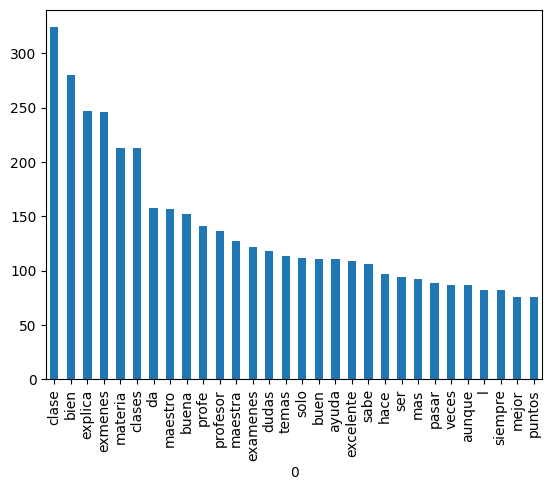

In [ ]:
flat_list = [ x for xs in df.clean_comments.values for x in xs]

temp = pd.DataFrame(flat_list).value_counts()[:30]
temp.index = temp.index.get_level_values(0)
temp.plot(kind = "bar")

<Axes: xlabel='bigrams'>

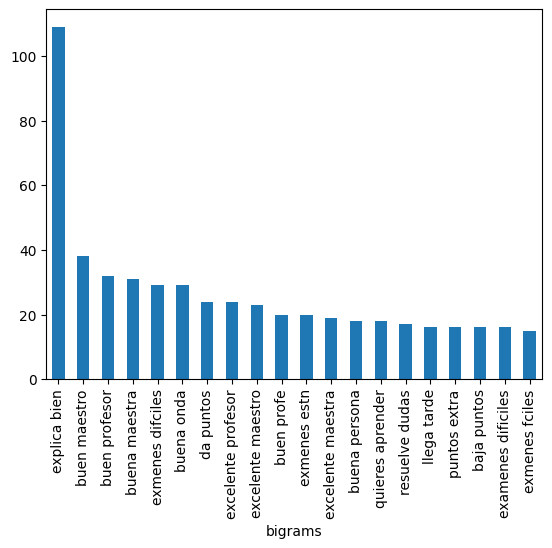

In [ ]:
from nltk import ngrams

texto_ = ' '.join(flat_list)

n = 2 # un bigrama
bigramas = ngrams(texto_.split(), n)
list_ = []
for gramas in bigramas:
  list_.append(gramas)
x = pd.DataFrame(list_)
x["bigrams"] = x[0] +" " +  x[1]
x.bigrams.value_counts()[0:20].plot(kind = "bar")

<Axes: xlabel='bigrams'>

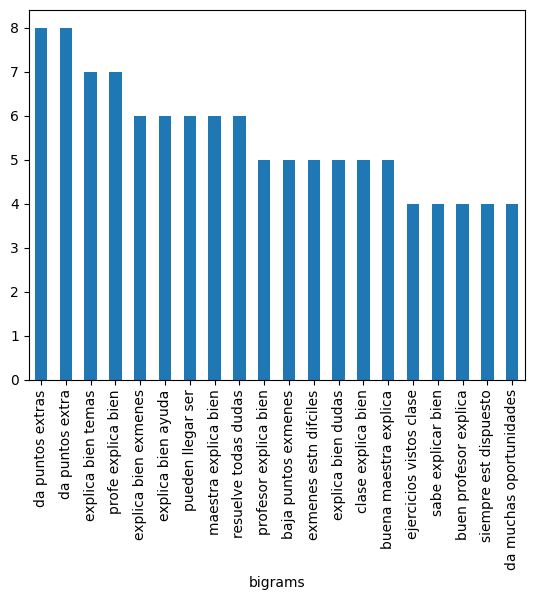

In [ ]:
from nltk import ngrams

texto_ = ' '.join(flat_list)
bigramas = ngrams(texto_.split(), 3)
list_ = []
for gramas in bigramas:
  list_.append(gramas)
x = pd.DataFrame(list_)
x["bigrams"] = x[0] +" " +  x[1] + " " + x[2]
x.bigrams.value_counts()[:20].plot(kind = "bar")

### Analisis por profesor

Enseguida se revisaran los comentarios de los 10 maestros que tienen más comentarios para contrastar si el alumno considera al maestro como ideal para llevar el curso con el/ ella.

para este caso sólo revisaremos bigramas.

### Profesor  0:

Por el conteo de frecuencia de palabras vemos que el profesor ha sido mal evaluado, con comentarios negativos.

### Profesor  1:

Por el conteo de frecuencia de palabras vemos que el profesor ha sido mal evaluado, con comentarios negativos, y al parecer tiene una mejor evaluación que el profesor 0.

### Profesor  2:
de aqui se puede ver que este profesor cuenta con buenas evaluaciones, por otro lado encontramos caracteristicas que no se esperaria de un maestro cómo openings anime. sin embargo a nivel general parece ser buena opción para tomar clase con el.

### Profesor  3:
El profesor no. 3 cuenta con comentarios que explican que este es un profesor "dificil" pero es un buen maestro, lo cuál resulta interesante debido a que una materia dificil no implica directamente un mal maestro.


### Profesor  4:
El profesor no. 4 cuenta con comentarios que explican que este es un profesor "facil" que explica bien y que la materia resulta sencilla.

### Conclusión
En conclusión podria verse que con el Análisis de frecuencias para texto nos permite interpretar los comentarios de una manera objetiva y comparable para tomar decisiones en este ejemplo mi opción de maestro asumiendo que los 5 maestros dieran la misma clase objetivamente tomaria el profesor número 3 por que es un buen maestro y permite llevar más allá la materia haciendola un poco dificil, sin embargo para un alumno que no le gusten los retos optará por el profesor número 4 el cuál hace que su contenido sera mucho más sencillo o facil.





profesor no:  0


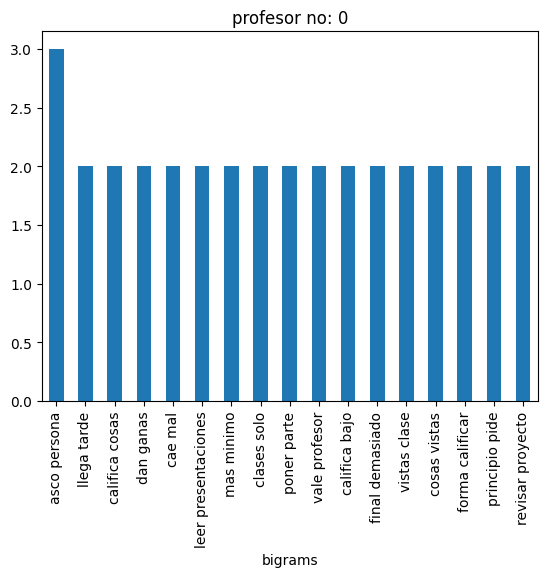

profesor no:  1


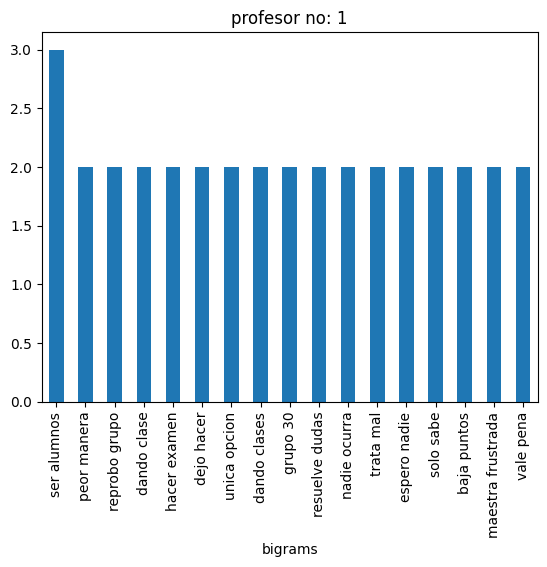

profesor no:  2


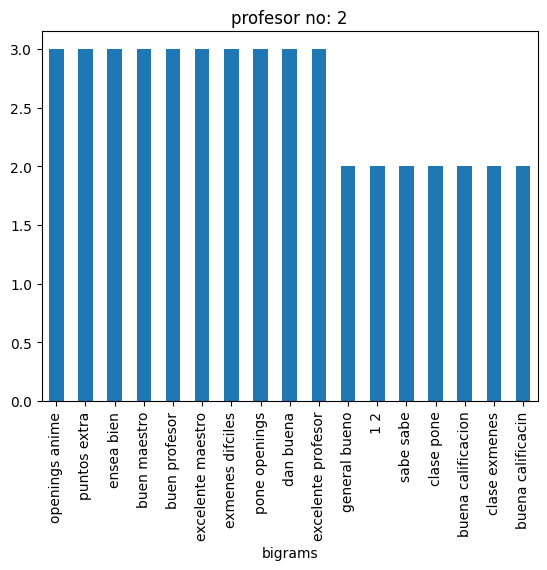

profesor no:  3


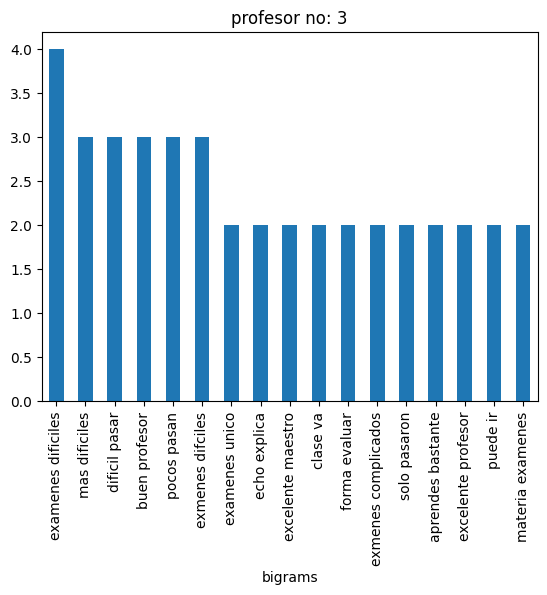

profesor no:  4


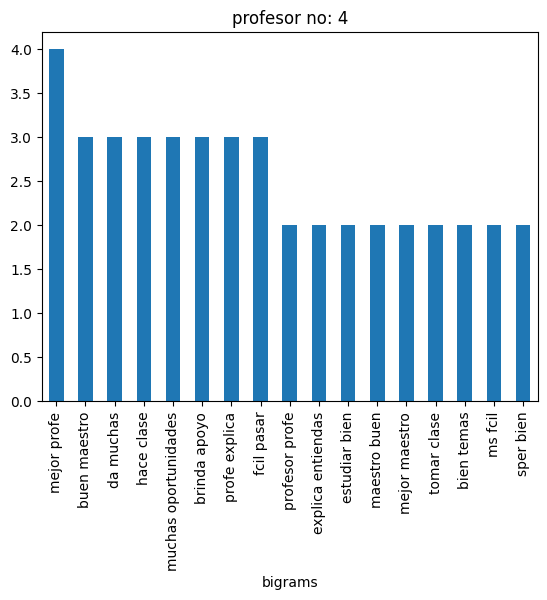

In [ ]:
import matplotlib.pyplot as plt
z = 5
for i,j in zip(prof2select[:5], range(5)):
    print("profesor no: ", j )
    to_transform = df[df.profesor == i].copy()
    flat_list = [ x for xs in to_transform.clean_comments.values for x in xs]
    texto_ = ' '.join(flat_list)
    bigramas = ngrams(texto_.split(), 2)
    list_ = []
    for gramas in bigramas:
        list_.append(gramas)
    x = pd.DataFrame(list_)
    x["bigrams"] = x[0] +" " +  x[1]
    x.bigrams.value_counts()[3:20].plot(kind = "bar")
    plt.title(f"profesor no: {j}")
    plt.show()